# Neuron Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Helper functions

In [2]:
def generate_spike_train(times_rates, jitter=0.):
    '''
    spike_times = generate_spike_train(times_rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    times_rates is an array or list of (t,r) pairs, so that the
        firing rate is changed to r (Hz) at time t (seconds).
        If the last firing rate is not zero, the last interval is
        extended for 1s, and then the rate goes to zero.
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
             s = generate_spike_train([[0.,10], [0.5,25], [2,0]])
    '''
    s = []
    tr = list(times_rates)
    rate_last = tr[-1][1]
    # Make sure it ends with a zero
    if rate_last != 0.:
        # If the last rate was not zero, extend for 1s and then set to 0.
        tr.append([tr[-1][0]+1., 0.])
    t = tr[0][0]
    for idx in range(0,len(tr)-1):
        t_interval = tr[idx+1][0] - t
        r = tr[idx][1]
        if r!=0:
            delta = 1. / r
            N = r * t_interval
            times = np.arange(t+delta/2., t+t_interval, delta)
            if jitter!=0.:
                times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = tr[idx+1][0]
    s.sort()
    return np.array(s)


def plot_spike_raster(st, y_range=None):
    '''
    plot_spike_raster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes  list of arrays of spike times
      y_range     2-tuple that holds the y-values that the raster ticks
                  should be drawn between
    '''
    N = len(st)  # number of neurons
    
    if y_range is None:
        y_range = [0, N-1]

    #loc = np.linspace(y_range[0], y_range[1], N)
    loc = np.linspace(0, N-1, N)
    if N==1:
        bin_radius = 0.5
    else:
        bin_radius = ( loc[1] - loc[0] ) / 2.
    ctr = []
    for n in range(N):
        nspikes = len(st[n])
        y = [ [loc[n]-bin_radius]*nspikes , [loc[n]+bin_radius]*nspikes ]
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim([y_range[0]-bin_radius, y_range[-1]+bin_radius])
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron index')
    return


def spikes_between(spiketrain, t_start, t_end):
    '''
     numspikes = spikes_between(spiketrain, t_start, t_end)

     Returns the number of times between t_start and t_end.
     Specifically, it counts a spike if it occurred at t, where
     t_start <= t < t_end
    
     Inputs:
       spiketrain   array-like list of spike times
       t_start      start time
       t_end        end time
       
     Output:
       numspikes    number of spikes, where t_start <= t < t_end
    '''
    sp_bool = np.logical_and( np.array(spiketrain)>=t_start, np.array(spiketrain)<t_end )
    return np.sum(sp_bool)

def random_array(n):
    '''
     w = random_array(n)
     
     Returns an array of n random numbers between 0 and 1.
     Note: The values are smoothed.
    '''
    a = np.random.random(size=(n,))
    b = np.zeros_like(a)
    omega = max(min(int(n/3.), 7), 1)
    b[:omega] = 1.
    b /= np.sum(b)
    return np.real(np.fft.ifft(np.fft.fft(a)*np.fft.fft(b)))

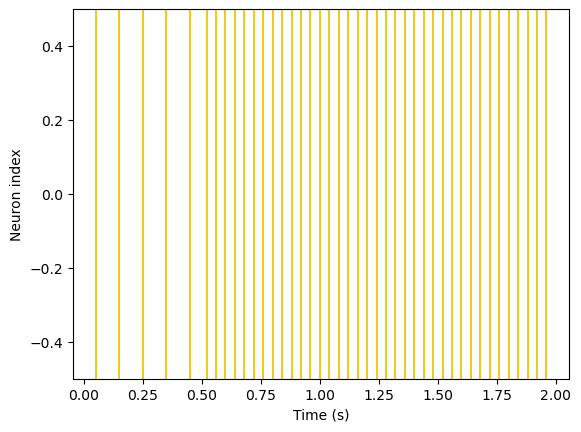

In [3]:
st = generate_spike_train([[0.,10], [0.5,25], [2,0]])
plot_spike_raster([st])

# Supposting Classes

## SpikingNetwork class
This class represents a collection of neurons and their connections to each other. Add neurons, connect them, and then simulate the network.

In [4]:
class SpikingNetwork():
    
    def __init__(self):
        '''
        net = SpikingNetwork()
        
        Constructor for SpikingNetwork class.
        
        The SpikingNetwork class contains a collection of neurons.
        It also has the code to simulate the network and display
        the resulting spike raster plots.
        '''
        self.neur = []         # List of neurons (of various kinds)
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
            
    def add_neuron(self, neur):
        '''
        net.add_neuron(neuron)
        
        Adds a neuron to the network.
        
        Input:
         neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neur.append(neur)
                
    def simulate(self, T, dt):
        '''
        net.simulate(T, dt)
        
        Simulates the network for T seconds by taking Euler steps
        of size dt.
        
        Inputs:
         T    how long to integrate for
         dt   time step for Euler's method
         
        The results of the simulation are stored in the individual neuron
        histories.
        '''
        
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        for tt in t_segment:
            self.t_history.append(tt)
            
            # Compute slopes for all neurons first...
            for neur in self.neur:
                neur.slope()
                
            # ... then update the neurons using an Euler step.
            for neur in self.neur:
                neur.step(dt)
                
    def all_spike_times(self):
        '''
        all_spikes = net.all_spike_times()
        
        Returns all the spikes of all the neurons in the network.
        Useful for making spike-raster plots of network activity.
        
        Output:
         all_spikes  a list of sublists, where each sublist holds
                     the spike times of one of the neurons
        '''
        all_spikes = []
        for neur in self.neur:
            all_spikes.append(np.array(neur.spikes))
        return all_spikes
    
    def spike_raster(self):
        '''
         net.spike_raster()
         
         Generate a spike raster plot.
        '''
        plot_spike_raster(self.all_spike_times())
        xlim = plt.axis()
        x = xlim[1]*1.01
        for idx,n in enumerate(self.neur):
            if n.label is not None:
                plt.text(x, idx, n.label);

## InputNeuron class
This class is for generating input to feed into a network.

In [5]:
class InputNeuron():
    '''
     A = InputNeuron(spiketrain, label=None)

     Constructor for InputNeuron class.

     InputNeuron is a class of neuron that can be used to inject spikes into
     the network. When involved in a simulation, an InputNeuron will generate
     spikes at the times specified during its construction.

     Inputs:
       spiketrain  array or list of spike times
       label       optional string
    '''    
    def __init__(self, spiketrain, label=None):
        self.t = 0.       # simulation time
        self.spikes = np.array(spiketrain)  # 1D array of spike times
        self.label = label   # just a simple text label
        
        self.axon = []    # list of outgoing connections
        # Each connection is a 2-tuple of the form (post,w), where "post" is the
        # receiving neuron, and w is the connection weight.
        
    def connect_to(self, post, w):
        '''
         A.connect_to(post, w)
         
         Connect an InputNeuron to another neuron with weight w.
         
         Inputs:
          post  LIFNeuron to receive this neuron's spikes
          w     weight of the connection
          
          Usage:
          To connect InputNeuron A to LIFNeuron B with weight 0.1
          > A.connect_to(B, 0.1)
        '''
        self.axon.append((post, w))

    def slope(self):
        # This neuron model is not governed by a DE
        return
    
    def step(self, dt):
        '''
         A.step(dt), take a time step of length dt
        '''
        # How many spikes are in this time step?
        n_spikes = spikes_between(self.spikes, self.t, self.t+dt)
        self.t += dt
        if n_spikes>0:
            self.send_spike(n_spikes)

    def send_spike(self, n=1):
        '''
         A.send_spike(n=1), send spike(s) to all connected-to neurons
        '''
        # Increment the incoming_spikes_buffer for each connected neuron
        for p,w in self.axon:
            p.incoming_spikes_buffer += n*w


# LIFNeuron class
Derived from the $Neuron$ class, this class implements the Leaky Integrate-and-Fire (LIF) neuron.
- The $slope$ function evaluates the right-hand side of the differential equations that govern the dynamics of the LIF neuron, and saves those slopes in its member variables $dvdt$ and $dsdt$.
- The $step$ advances the neuron’s state one time step using $dvdt$ and $dsdt$.

In [6]:
class LIFNeuron():

    def __init__(self, Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05, label=None):
        '''
         lif = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)
        
         Constructor for LIFNeuron class
        
         Inputs:
           Tau_m   membrane time constant, in seconds (s)
           Tau_ref refractory period (s)
           Tau_s   synaptic time constant (s)
           label   optional string
        '''
        self.label = label      # string label
        self.t  = 0.            # simulation time
        self.tau_m = Tau_m      # membrane time constant
        self.tau_ref = Tau_ref  # refractory period
        self.tau_s = Tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        
        self.axon = []    # list of outgoing connections
        # Each connection is a 2-tuple of the form (post,w), where "post" is the
        # receiving neuron, and w is the connection weight.

        # The incoming_spikes_buffer tabulates all the spikes that arrive in a time step,
        # weighting each incoming spike by the corresponding connection weight.
        # This buffer simply adds together all the incoming spikes for one time step.
        self.incoming_spikes_buffer = 0.  # weighted sum of incoming spikes (for one time step)
        
        # In the next time step, the incoming_spikes_buffer is injected into the input
        # current. So we make a copy, called I, and will use it in the appropriate place
        # on the RHS of the differential equation for s.
        self.I = 0.             # current injected by arriving spikes
        
        # For plotting
        self.v_history = []     # records v over time
        self.s_history = []     # records s over time
        self.spikes = []        # list of times when this neuron spiked
    
    def connect_to(self, post, w):
        '''
         lif.connect_to(post, w)
         
         Connect a LIF neuron to another, with weight w.
         
         Inputs:
          post  LIFNeuron to receive this neuron's spikes
          w     weight of the connection
        '''
        self.axon.append((post, w))
        
        
    def slope(self):
        '''
         lif.slope()
        
         Evaluates the right-hand side of the differential equations that
         govern v and s. This function does NOT include incoming spikes.
         
         There is no output; the method simply updates the member variables
            self.dvdt, and
            self.dsdt
         which are used by the step method.
        '''
        # Copy the incoming_spikes_buffer, then reset it for the
        # upcoming "step" process. We do this because the step process
        # increments the incoming_spikes_buffer for neurons that
        # receive spikes.
        self.I = self.incoming_spikes_buffer
        self.incoming_spikes_buffer = 0.
        
        #===============
        
        self.dvdt = (self.s-self.v)/self.tau_m  # replace these lines
        self.dsdt = -self.s/self.tau_s
        #===============            

        
    def step(self, dt):
        '''
         LIFNeuron.step(dt)
        
         Updates the LIF neuron state by taking an Euler step in v and s.
         The length of the step is dt seconds.
         
         Input
          dt       time step (in seconds)
          
         If v reaches the threshold of 1, the neuron fires an action potential
         (spike). Linear interpolation is used to estimate the time that v=1.
         The spike time is appended to the list self.spikes, and v
         is set to zero. After a spike, the neuron is dormant for self.tau_ref
         seconds.
        '''
        # self.I includes all the input from spikes in the last time step
        
        #===============
        # Update synaptic input
        self.s += self.dsdt * dt
        self.s += self.I/self.tau_s

        # Check if the neuron is in a refractory period
        if (self.ref_remaining - dt) > 0:
            # If it is, reset the membrane potential to 0
            self.v = 0
            self.ref_remaining -= dt
            
        else:
            # For the normal case
            if self.ref_remaining <= 0:
                time_integrate = dt
                
            # Case when the refractory period ends part-way through a time step
            else:
                time_integrate = dt - self.ref_remaining
                
            # Find the start time of the integrating
            integrate_step_start = self.t + dt - time_integrate
            # Set ref_remaining back to 0
            self.ref_remaining = 0
            
            # Store the previous membrane potential
            prev_v = self.v
            # Update the membrane potential using Euler's method
            self.v += self.dvdt * time_integrate

            # Check if the membrane potential has reached the threshold (1.0)
            if self.v >= 1.0:
                # Update time t when there is a spike
                self.t += dt
                
                # If membrane potential exceeds threshold
                if self.v > 1.0:
                    # Send a spike to connected neurons
                    self.send_spike()
                    # Reset refractory period timer to tau_ref
                    self.ref_remaining = self.tau_ref
                    
                    # Find slope
                    exact_slope = ((self.v - prev_v) /
                                   (self.t - integrate_step_start))
                    # If the potential exceeds 1.0, interpolate to find spike time
                    spike_time = integrate_step_start + (1.0 - prev_v) / exact_slope
                    # Update refractory period time remaining
                    self.ref_remaining -= (self.t - spike_time)
                    
                else:
                    # No need for interpolation for this case
                    # Send a spike to connected neurons
                    self.send_spike()
                    # Reset refractory period timer to tau_ref
                    self.ref_remaining = self.tau_ref
                    # Record spike time
                    spike_time = self.t

                # Append spike time to the list of spikes
                self.spikes.append(spike_time)
        
        #===============

        # Store v (for plotting), and reset incoming spike accumulator
        self.v_history.append(self.v)
        self.s_history.append(self.s)
        self.t += dt     # step forward in time
                
    def __repr__(self):
        '''
         lif.print(neur)
         
         Prints the current time, membrane potential, input current, and
         remaining refractory time.
        '''
        s = f'{self.t:6.4f}s: s={self.s:5.3f}, v={self.v:6.4f}, ref remaining={self.ref_remaining:7.5f}s'
        return s
    
    def send_spike(self):
        '''
         lif.send_spike()
         
         Send a spike to all the neurons that this neuron is connected to.
        '''
        # Increment the incoming_spikes_buffer for each connected neuron
        for p,w in self.axon:
            p.incoming_spikes_buffer += w

## Tests

In [7]:
# Test current variable, s
net = SpikingNetwork()
# One spike at t=0, which will affect A's input current in the next time step.
inA = InputNeuron([0.], label='inA')
A = LIFNeuron(label='A')
net.add_neuron(inA)     # neuron index 0
net.add_neuron(A)       # neuron index 1
inA.connect_to(A, 0.5)  # connect inA -> A
net.simulate(0.002, 0.001)

print(net.neur[1].s_history)
#print(A.s_history)  # equivalent to line above

print('\nExpected output')
print('[0.0, 10.0]')

[0.0, 10.0]

Expected output
[0.0, 10.0]


In [8]:
# Test interpolated spike time
net = SpikingNetwork()
A = LIFNeuron(label='A')
net.add_neuron(A)

# Set voltage and current so it's just about to spike.
A.v = 0.95
A.s = 10.

net.simulate(0.001, 0.001)

print(np.round(A.spikes,5))

print('\nExpected output')
print('[0.00011]')

[0.00011]

Expected output
[0.00011]


# Two LIF Neurons

Build the network with two LIFNeurons $A$ and $B$, each projecting its output to the other. That is, $neuron A$ is connected to $neuron B$ with a weight of 0.05, and $B$ is connected to $A$ with a weight of 0.05. Set the refractory period for $A$ and $B$ to 8 ms (ie. Tau_ref=0.008).

Add an input neuron, called $InA$, and connect it to $neuron A$ with a weight of 0.2. Have $neuron InA$ fire at 60 Hz for 0.1
seconds at the start, and then go silent. You can create that input neuron using

InA = InputNeuron(generate_spike_train([[0,60], [0.1,0]]))

Add another input neuron, called $InB$, that connects to $neuron B$. $Neuron InB$ should be silent, except fire at 80 Hz starting at 1.5 s and ending at 1.6 s. Connect $InB$ to $neuron B$ with a weight of -0.5.

In [9]:
# Build and simulate the network
net = SpikingNetwork()

# Create LIFNeurons A and B
A = LIFNeuron(Tau_m=0.02, Tau_ref=0.008, Tau_s=0.05)
B = LIFNeuron(Tau_m=0.02, Tau_ref=0.008, Tau_s=0.05)

# Create input neuron InA with spike train
spike_train_InA = generate_spike_train([[0, 60], [0.1, 0]])
InA = InputNeuron(spike_train_InA)

# Create input neuron InB with spike train
spike_train_InB = generate_spike_train([[0, 0], [1.5, 80], [1.6, 0]])
InB = InputNeuron(spike_train_InB)

# Connect neurons as described
A.connect_to(B, 0.05)
B.connect_to(A, 0.05)
InA.connect_to(A, 0.2)
InB.connect_to(B, -0.5)

# Add neurons to the network
net.add_neuron(A)
net.add_neuron(B)
net.add_neuron(InA)
net.add_neuron(InB)
#==============


Simulate the network for 2 seconds, and produce a spike-raster plot for the four neurons in the network.

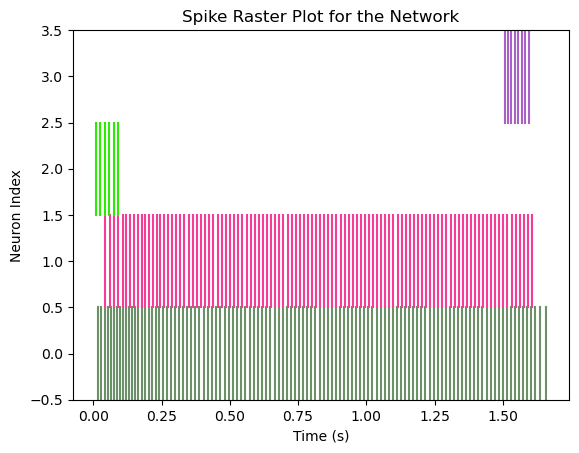

In [10]:
# Simulate the network for 2 seconds with a time step of 1 ms
net.simulate(2.0, 0.001)

# Plot spike raster
net.spike_raster()
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Spike Raster Plot for the Network')
plt.show()
#==============


# Ring Oscillator

Create a network with $n$ LIF neurons; for the sake of this question, let’s label them $N_0$ through $N_n−1$. For all n neurons, use $Tau_m = 100$ ms, and $Tau_s = 200$ ms. Connect $N_0$ to $N_1$ with a weight of $0.4$. Likewise, connect $N_1$ to $N_2$ with a weight of $0.4$, etc., until we finally close the loop by connecting $N_n−1$ to $N_0$ with a weight of $0.4$. This is the excitatory ring.

In [11]:
# Function to create a network with n LIF neurons and an excitatory ring
def create_ring_oscillator(n):
    net = SpikingNetwork()
    neurons = []

    for i in range(n):
        neuron = LIFNeuron(Tau_m=0.1, Tau_s=0.2, label=f'N{i}')
        neurons.append(neuron)
        net.add_neuron(neuron)

    for i in range(n):
        neurons[i].connect_to(neurons[(i + 1) % n], 0.4)
        
    return net
    
#==============

Add inhibitory connections between the same pairs of neurons, but running in the opposite direction around the ring. That is, connect $N_1$ to $N_0$ with a weight of $-0.8$, and $N_0$ to $N_n−1$ with a weight of $-0.8$, etc. This is the inhibitory ring.

In [12]:
# Function to create a network with n LIF neurons and an excitatory ring
def create_ring_oscillator(n):
    net = SpikingNetwork()
    neurons = []

    for i in range(n):
        neuron = LIFNeuron(Tau_m=0.1, Tau_s=0.2, label=f'N{i}')
        neurons.append(neuron)
        net.add_neuron(neuron)

    for i in range(n):
        neurons[i].connect_to(neurons[(i + 1) % n], 0.4)
    
    for i in range(n):
        neurons[i].connect_to(neurons[(i - 1) % n], -0.8)
    
    return net

#==============

Add an input neuron to stimulate any one of the ring neurons (with a weight of $0.2$). This input neuron should have a firing rate of $25$ Hz for the first $0.3$ seconds, and then go dormant.

In [13]:
# Function to create a network with n LIF neurons and an excitatory ring
def create_ring_oscillator(n, neuron_ind):
    net = SpikingNetwork()
    neurons = []

    for i in range(n):
        neuron = LIFNeuron(Tau_m=0.1, Tau_s=0.2, label=f'N{i}')
        neurons.append(neuron)
        net.add_neuron(neuron)

    for i in range(n):
        neurons[i].connect_to(neurons[(i + 1) % n], 0.4)
    
    for i in range(n):
        neurons[i].connect_to(neurons[(i - 1) % n], -0.8)
    
    input_neuron = InputNeuron(generate_spike_train([[0, 25], [0.3, 0]]))
    input_neuron.connect_to(neurons[neuron_ind], 0.2)
    net.add_neuron(input_neuron)
    
    return net

#==============

Simulate the network for $4$ seconds, and produce a spike-raster plot of all the neurons in the network. We see all the neurons in the ring exhibit a “burst” of spikes in sequence. This excitation travels like a wave around the ring.

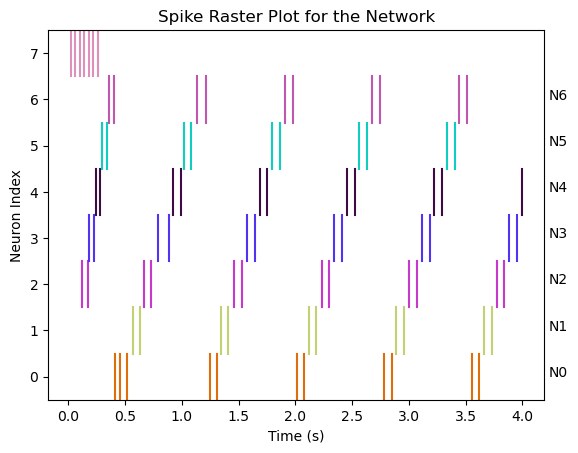

The period of the oscillator is 0.7326879390617174 seconds


In [14]:
# Simulate the network for 4 seconds with a time step of 1 ms
net = create_ring_oscillator(7, 2)
net.simulate(4.0, 0.001)

# Plot spike raster
net.spike_raster()
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Spike Raster Plot for the Network')
plt.show()

# For the wave of activity to go around the ring, let's consider Neuron #2
# List spike_time of Neuron #2
spike_times_N2 = net.neur[2].spikes

# Calculate time differences between non-consecutive spikes
period_estimates_1 = np.diff(spike_times_N2[::2])
period_estimates_2 = np.diff(spike_times_N2[1::2])

# Estimate the period as the average of time differences
period_estimates = np.concatenate((period_estimates_1,period_estimates_2), axis=0)
estimated_period = np.mean(period_estimates)

print(f'The period of the oscillator is {estimated_period} seconds')  # adjust this line
#==============